In [1]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

In [2]:
data_tr = pd.read_csv("dataset/labels_tr.csv")

In [3]:
data_val = pd.read_csv("dataset/labels_val.csv")

In [4]:
train_data = np.zeros((25), dtype=int)
for i in range (0, len(data_tr), 25):
    train_data = np.vstack((train_data, data_tr['predicted'].loc[i:i+24].values.astype(np.int64)))
train_data = np.delete(train_data, 0, 0)

In [5]:
val_data = np.zeros((25), dtype=int)
for i in range (0, len(data_val), 25):
    val_data = np.vstack((val_data, data_val['predicted'].loc[i:i+24].values.astype(np.int64)))
val_data = np.delete(val_data, 0, 0)

In [7]:
actual_train = np.zeros((25), dtype=int)
for i in range (0, len(data_tr), 25):
    actual_train = np.vstack((actual_train, data_tr['target'].loc[i:i+24].values.astype(np.int64)))
actual_train = np.delete(actual_train, 0, 0)

actual_val = np.zeros((25), dtype=int)
for i in range (0, len(data_val), 25):
    actual_val = np.vstack((actual_val, data_val['target'].loc[i:i+24].values.astype(np.int64)))
actual_val = np.delete(actual_val, 0, 0)

In [8]:
val_data.shape

(240, 25)

In [20]:
def extract_label(input_data):
    labels = []
    for seq in input_data:
        prev_val = 0
        if np.all(seq == np.zeros(seq.shape)):
            labels.append(0)
            continue
        for i, val in enumerate(seq):
            if val == 1 and prev_val == 0:
                labels.append(i - 4)
                break
    
    return np.array(labels)


In [21]:
train_labels = extract_label(actual_train)
print(train_labels.shape)
val_labels = extract_label(actual_val)
print(val_labels.shape)

(1015,)
(240,)


In [11]:
def encode_targets(input_data):
    encoded_targets = []
    for sequence in input_data:
        target = [0] * len(sequence)
        prev_val = 0
        for i, val in enumerate(sequence):
            if val == 1 and prev_val == 0:
                target[i] = 1
            prev_val = val
        encoded_targets.append(target)
    return encoded_targets

labels_train = encode_targets(train_data)
labels_train = np.array(labels_train)

In [9]:
labels_val = encode_targets(val_data)
labels_val = np.array(labels_val)

In [10]:
actual_train_labels = encode_targets(actual_train)
actual_train_labels = np.array(actual_train_labels)


actual_val_labels = encode_targets(actual_val)
actual_val_labels = np.array(actual_val_labels)

In [11]:
#train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], 1))
#val_data = np.reshape(val_data, (val_data.shape[0], val_data.shape[1], 1))
train_data.shape

(1015, 25)

In [12]:
val_data.shape

(240, 25)

In [13]:
train_tensor = torch.from_numpy(train_data).float()
train_tensor = train_tensor.unsqueeze(2)

val_tensor = torch.from_numpy(val_data).float()
val_tensor = val_tensor.unsqueeze(2)

target_tensor = torch.from_numpy(labels_train).float()


In [14]:
#target_tensor.unsqueeze_(2)

In [15]:
target_tensor.shape

torch.Size([1015, 25])

In [16]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.array([0, 1])), y=target_tensor.numpy().flatten())
class_weights = torch.tensor(class_weights, dtype=torch.float32)#.to(device)
print(class_weights)

tensor([ 0.5150, 17.2151])


In [17]:
class_weights = torch.tensor([0.5150, 17.2151], dtype=torch.float32)

In [18]:
import torch.optim as optim

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)  # Fully connected layer for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)
        out = self.sigmoid(out)
        return out

# Hyperparameters
input_size = 1  # Input feature size
hidden_size = 64
num_layers = 1
num_epochs = 400
learning_rate = 0.005
batch_size = 1

# Create the model
model = BiLSTM(input_size, hidden_size, num_layers)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(train_tensor)
    loss = criterion(outputs.view(-1), target_tensor.view(-1))
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Train predictions
with torch.no_grad():
    predictions = model(train_tensor)
    predicted_transition_frames = (predictions > 0.5).int()
predicted_train = predicted_transition_frames.squeeze().numpy()


#val predictions
with torch.no_grad():
    predictions = model(val_tensor)
    predicted_transition_frames = (predictions > 0.5).int()
predicted_val = predicted_transition_frames.squeeze().numpy()


Epoch [10/400], Loss: 7382.5425
Epoch [20/400], Loss: 7146.0913
Epoch [30/400], Loss: 7036.6855
Epoch [40/400], Loss: 6956.2563
Epoch [50/400], Loss: 6917.3877
Epoch [60/400], Loss: 6886.5474
Epoch [70/400], Loss: 6852.4194
Epoch [80/400], Loss: 6834.5142
Epoch [90/400], Loss: 6815.3823
Epoch [100/400], Loss: 6801.1035
Epoch [110/400], Loss: 6791.4834
Epoch [120/400], Loss: 6786.1235
Epoch [130/400], Loss: 6782.6299
Epoch [140/400], Loss: 6780.1870
Epoch [150/400], Loss: 6778.6484
Epoch [160/400], Loss: 6777.6455
Epoch [170/400], Loss: 6776.9360
Epoch [180/400], Loss: 6776.4131
Epoch [190/400], Loss: 6776.0039
Epoch [200/400], Loss: 6775.6787
Epoch [210/400], Loss: 6775.4150
Epoch [220/400], Loss: 6775.1958
Epoch [230/400], Loss: 6775.0122
Epoch [240/400], Loss: 6774.8540
Epoch [250/400], Loss: 6774.7168
Epoch [260/400], Loss: 6774.5972
Epoch [270/400], Loss: 6774.4995
Epoch [280/400], Loss: 6774.4370
Epoch [290/400], Loss: 6774.3311
Epoch [300/400], Loss: 6774.2520
Epoch [310/400], Lo

In [21]:
data = pd.DataFrame(predicted_train)
data.to_csv('predicted_train.csv', index=False)

In [22]:
data = pd.DataFrame(predicted_val)
data.to_csv('predicted_val.csv', index=False)

In [23]:
actual_train_labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Text(0.5, -0.1, 'F1 score: 0.93')

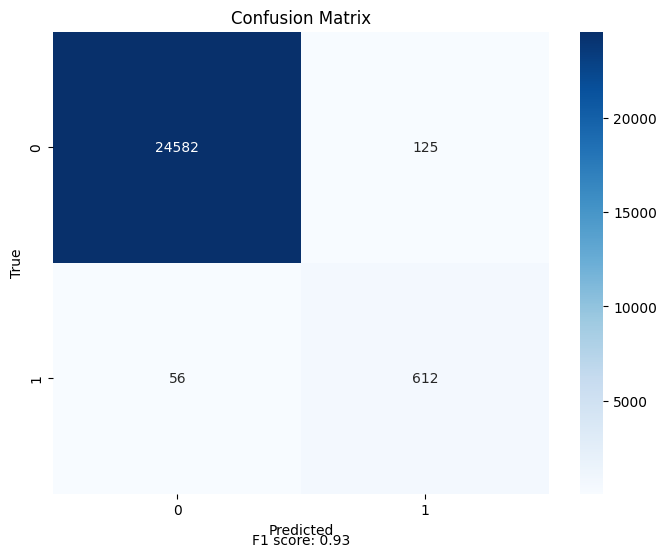

In [24]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(actual_train_labels.flatten(), predicted_train.flatten())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

f1 = f1_score(actual_train_labels.flatten(), predicted_train.flatten(), average='macro')
plt.text(0.5, -0.1, f'F1 score: {f1:.2f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
#plt.savefig(file_dir + f"/confmat_{epoch+1}.png")
#plt.close()

Text(0.5, -0.1, 'F1 score: 0.53')

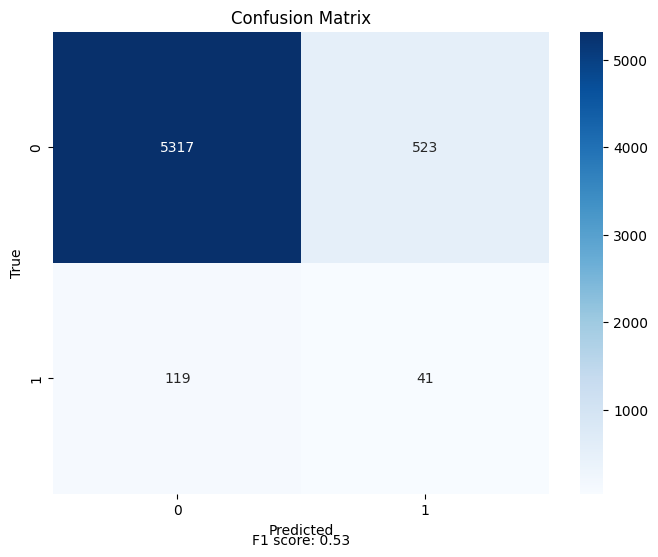

In [25]:
cm = confusion_matrix(actual_val_labels.flatten(), predicted_val.flatten())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

f1 = f1_score(actual_val_labels.flatten(), predicted_val.flatten(), average='macro')
plt.text(0.5, -0.1, f'F1 score: {f1:.2f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
#plt.savefig(file_dir + f"/confmat_{epoch+1}.png")
#plt.close()

In [26]:
acc_train = np.mean(actual_train_labels.flatten() == predicted_train.flatten())
print(f'Accuracy: {acc_train * 100:.2f}%')

acc_val = np.mean(actual_val_labels.flatten() == predicted_val.flatten())
print(f'Accuracy: {acc_val * 100:.2f}%')

Accuracy: 99.29%
Accuracy: 89.30%
